# **Tópicos Selectos en Aprendizaje Maquinal**

**Doctorado en Ingeniería: mención en Señales, Sistemas e Inteligencia Computacional**

**FICH - UNL -** **Instituto de investigación en Señales, Sistemas e Inteligencia Computacional**

<img src=http://sinc.unl.edu.ar/wp-content/themes/sinci/img/sinc-logo.png width="150">


Consultas: *Leandro Vignolo*
ldvignolo@sinc.unl.edu.ar

## **Trabajo práctico Nº 2: problemas de clasificación con datos reales**

**Modificar los parámetros correspondientes a cada método de clasificación y de validación cruzada, según se indica en la guía de TP disponible en http://tsam-fich.wikidot.com/apuntes**

**Para una referencia de los métodos y sus parámetros ver la documentación de sklearn en https://scikit-learn.org/**


---


***Guardar una copia personal de la Colab para trabajar en ella y guardar los cambios***


---




### **Carga de librerías**

In [31]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from collections import Counter
import numpy as np
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from warnings import simplefilter
import time
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# instalar librería adicional para el método Relief
!pip install sklearn-relief
import sklearn_relief as relief

# Para una referencia detallada de los métodos empleados y los parámetros correspondientes ver la documentación de sklearn en https://scikit-learn.org/stable/index.html


### **Definiciones de clasificadores**
***Modificar los parámetros de cada método***


Naive Bayes

In [32]:
# 1 Naive Bayes
def clf_NB(X_train, X_test, y_train, y_test):

    classes = np.unique(y_train)
    nt = y_train.shape[0]
    props = []
    for i in range(0,len(classes)):
        props.append( np.sum(y_train==classes[i])/nt )

    bayes = GaussianNB(priors=props, var_smoothing=1e-09)
    # entrenamiento
    bayes.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = bayes.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Perceptrón Multicapa

In [33]:
# 2 MLP
def clf_MLP(X_train, X_test, y_train, y_test):
    clf = MLPClassifier(hidden_layer_sizes = (5, 3),      # arquitectura de la red
                        activation = 'relu',              # función de activación
                        solver = 'adam',                  # algoritmo de optimización
                        learning_rate_init = 0.001,       # tasa de aprendizaje
                        max_iter = 300,                   # épocas de entrenamiento
                        tol = 0.0000001,                  # tolerancia de error
                        verbose = False)                  # mostrar salida durante entrenamiento
    # entrenamiento
    clf.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Red Nuronal con Funciones de Base Radial

In [34]:
# 3 RBF
def clf_RBF(X_train, X_test, y_train, y_test):

    # entreno centroides con Kmeans usando datos de train
    model = KMeans(n_clusters=8)                 # definir cantidad de centroides
    model.fit(X_train)

    sigma = np.ones(model.n_clusters)
    Z_train = np.empty([X_train.shape[0],model.n_clusters])
    Z_test  = np.empty([X_test.shape[0],model.n_clusters])
    # calculo salidas de la capa RBF (mapeo)
    for clus in range(0,model.n_clusters):
        # estimación de la STD media para cada clúster/centroide sobre datos de entrenamiento
        aux = X_train[model.labels_==clus]
        if len(aux)!=0:                                # si el centroide no quedó sin patrones
            sigma[clus] = np.mean(np.std(aux,axis=0))  # STD promedio sobre las dimensiones
        if (sigma[clus]==0):
            sigma[clus] = 1.0
        # obtengo la salida de cada RBF con datos de train y test
        # las salidas las RBF son las nuevas features y las guardo en las columnas de los array para train y test
        Z_train[:,clus] = rbf_kernel([model.cluster_centers_[clus]], X_train, gamma=1.0/(sigma[clus]**2)).reshape(X_train.shape[0])
        Z_test[:,clus]  = rbf_kernel([model.cluster_centers_[clus]], X_test,  gamma=1.0/(sigma[clus]**2)).reshape(X_test.shape[0])

    # defino y entreno la capa de salida
    clf = Perceptron(tol=1e-3, random_state=0)   # definir tolerancia de error
    clf.fit(Z_train, y_train)
    # obtengo las predicciones de la capa de salida para los datos de prueba
    y_pred = clf.predict(Z_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Árbol de Decisión

In [35]:
## 4 Árbol de decisión
def clf_TREE(X_train, X_test, y_train, y_test):
    dtree = DecisionTreeClassifier(random_state=0, max_depth=2) # definición y seteo de parámetros del clasificador
    # entrenamiento
    dtree.fit(X_train, y_train)
    # prueba
    y_pred = dtree.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Random Forest

In [36]:
## 5 RandomForest
def clf_RF(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=100) # parámetros del clasificador RandomForest
    # entrenamiento
    clf.fit(X_train, y_train)
    # prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Máquina de Soporte Vectorial

In [62]:
from sklearn.svm import SVC # Import the SVC class

## 7 FEATURE SELECTION + SVM
def clf_FS_SVM(X_train, X_test, y_train, y_test):

    # defino el método de ranking con criterio de ANOVA F (f_classif)
    FS = SelectKBest(f_classif, k=2)        # definir cuántas características se desean seleccionar
    # realizo la selección en base a datos de train
    FS = FS.fit(X_train, y_train)
    # mapeo / aplico la selección en train y test
    X_train_new = FS.transform(X_train)
    X_test_new  = FS.transform(X_test)
    # defino clasificador SVM
    # Use SVC directly here instead of svm.SVC:
    clf = SVC(kernel='rbf', gamma=1) # Kernel RBF
    # entreno el clasificador
    clf.fit(X_train_new, y_train)
    # predicción en datos de prueba
    y_pred = clf.predict(X_test_new)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train_new.shape[1]
    return acc, uar, rec, nf

Método de Selección de Características y Máquina de Soporte Vectorial

In [38]:
## 7 FEATURE SELECTION + SVM
def clf_FS_SVM(X_train, X_test, y_train, y_test):

    # defino el método de ranking con criterio de ANOVA F (f_classif)
    FS = SelectKBest(f_classif, k=2)        # definir cuántas características se desean seleccionar
    # realizo la selección en base a datos de train
    FS = FS.fit(X_train, y_train)
    # mapeo / aplico la selección en train y test
    X_train_new = FS.transform(X_train)
    X_test_new  = FS.transform(X_test)
    # defino clasificador SVM
    clf = svm.SVC(kernel='rbf', gamma=1) # Kernel RBF
    # entreno el clasificador
    clf.fit(X_train_new, y_train)
    # predicción en datos de prueba
    y_pred = clf.predict(X_test_new)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train_new.shape[1]
    return acc, uar, rec, nf

Autoencoder y Máquina de Soporte Vectorial

In [39]:
## 8 Autoencoder + SVM

def clf_AE_SVM(X_train, X_test, y_train, y_test, plot=False, ax1=None, ax2=None):


    n_input = len(X_train[0])
    # Estructura del codificador
    n_encoder1 = 500
    n_encoder2 = 300
    n_latent = 2
    # Estructura del decodificador
    n_decoder2 = 300
    n_decoder1 = 500
    # definición del Autoencoder
    AE = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1),
                      activation = 'tanh',
                      solver = 'adam',
                      learning_rate_init = 0.0001,
                      max_iter = 300,
                      tol = 0.0000001,
                      verbose = False)

    # Entrenamiento del autoencoder
    AE.fit(X_train, X_train)

    # defino función para obtener representación latente
    def encoder(data):
        data = np.asmatrix(data)
        encoder1 = data*AE.coefs_[0] + AE.intercepts_[0]
        encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
        encoder2 = encoder1*AE.coefs_[1] + AE.intercepts_[1]
        encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
        latent = encoder2*AE.coefs_[2] + AE.intercepts_[2]
        latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
        return np.asarray(latent)

    # mapeo train / test
    train_latent = encoder(X_train)
    test_latent = encoder(X_test)

    if plot:
        ax1.scatter(train_latent[:,0], train_latent[:,1], s=50, c=y_train, marker="o")
        ax1.set_xlabel("Latent1")
        ax1.set_ylabel("Latent2")
        ax1.set_title("Train Data")
        ax2.scatter(test_latent[:,0],  test_latent[:,1],  s=50, c=y_test, marker="o")
        ax2.set_xlabel("Latent1")
        ax2.set_ylabel("Latent2")
        ax2.set_title("Test Data")

    # entrenamiento de un SVM empleando la representación latente
    #clf = svm.SVC(kernel='linear') # SVM Kernel lineal
    clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM kernel polinomial
    #clf = svm.SVC(kernel='rbf',gamma=1) # SVM Kernel RBF
    clf.fit(train_latent, y_train)
    y_pred = clf.predict(test_latent)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = train_latent.shape[1]
    return acc, uar, rec, nf

k-Medias

In [40]:
## 9 k-means
def clf_kMeans(X_train, X_test, y_train, y_test):
    # entreno el algoritmo de clustering
    model = KMeans(n_clusters=8)
    model.fit(X_train)

    # defino vector para asignar las etiquetas a los datos de entrenamiento
    train_Labels = np.empty(len(X_train))
    # defino vector para asignar una etiqueta de clase a cada clúster
    cluster_labels = np.empty(model.n_clusters)
    # para cada clúster
    for clus in range(0,model.n_clusters):
        # model.labels_ indica el clúster al que pertenece cada patrón
        original_labels = y_train[model.labels_==clus]
        # original_labels contiene las etiquetas de los elementos del clúster
        count = Counter(original_labels)
        # asigno etiqueta de clase a cada clúster
        cluster_labels[clus] = max(count, key=count.get)
        # asigno etiqueta de clase a cada patrón de train en ese clúster
        train_Labels[model.labels_==clus] = cluster_labels[clus]

    # obtengo un clúster para cada dato de test
    clus_test_pred = model.predict(X_test)
    # obtengo etiqueta para cada dato de test
    y_pred = cluster_labels[clus_test_pred]
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

### **Ejercicio 1: dataset "Diabetes"**


In [41]:
def clf_NB_conf1(X_train, X_test, y_train, y_test):
    bayes = GaussianNB(priors=None, var_smoothing=1e-09)
    # entrenamiento
    bayes.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = bayes.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

def clf_NB_conf2(X_train, X_test, y_train, y_test):
    bayes = GaussianNB(priors=None, var_smoothing=1e-05)
    # entrenamiento
    bayes.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = bayes.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

In [42]:
def clf_MLP1(X_train, X_test, y_train, y_test):
    clf = MLPClassifier(hidden_layer_sizes=(8,4),
                         activation='relu',
                         solver='adam',
                         learning_rate_init=0.001,
                         max_iter=300)               # mostrar salida durante entrenamiento
    # entrenamiento
    clf.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

def clf_MLP2(X_train, X_test, y_train, y_test):
    clf = MLPClassifier(hidden_layer_sizes=(16,16),
                         activation='tanh',
                         solver='sgd',
                         learning_rate_init=0.01,
                         max_iter=500)              # mostrar salida durante entrenamiento
    # entrenamiento
    clf.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

In [43]:
# 3 RBF
def clf_RBF1(X_train, X_test, y_train, y_test):

    # entreno centroides con Kmeans usando datos de train
    model = KMeans(n_clusters=8)                 # definir cantidad de centroides
    model.fit(X_train)

    sigma = np.ones(model.n_clusters)
    Z_train = np.empty([X_train.shape[0],model.n_clusters])
    Z_test  = np.empty([X_test.shape[0],model.n_clusters])
    # calculo salidas de la capa RBF (mapeo)
    for clus in range(0,model.n_clusters):
        # estimación de la STD media para cada clúster/centroide sobre datos de entrenamiento
        aux = X_train[model.labels_==clus]
        if len(aux)!=0:                                # si el centroide no quedó sin patrones
            sigma[clus] = np.mean(np.std(aux,axis=0))  # STD promedio sobre las dimensiones
        if (sigma[clus]==0):
            sigma[clus] = 1.0
        # obtengo la salida de cada RBF con datos de train y test
        # las salidas las RBF son las nuevas features y las guardo en las columnas de los array para train y test
        Z_train[:,clus] = rbf_kernel([model.cluster_centers_[clus]], X_train, gamma=1.0/(sigma[clus]**2)).reshape(X_train.shape[0])
        Z_test[:,clus]  = rbf_kernel([model.cluster_centers_[clus]], X_test,  gamma=1.0/(sigma[clus]**2)).reshape(X_test.shape[0])

    # defino y entreno la capa de salida
    clf = Perceptron(tol=1e-3, random_state=0)   # definir tolerancia de error
    clf.fit(Z_train, y_train)
    # obtengo las predicciones de la capa de salida para los datos de prueba
    y_pred = clf.predict(Z_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf


# 3 RBF
def clf_RBF2(X_train, X_test, y_train, y_test):

    # entreno centroides con Kmeans usando datos de train
    model = KMeans(n_clusters=16)                 # definir cantidad de centroides
    model.fit(X_train)

    sigma = np.ones(model.n_clusters)
    Z_train = np.empty([X_train.shape[0],model.n_clusters])
    Z_test  = np.empty([X_test.shape[0],model.n_clusters])
    # calculo salidas de la capa RBF (mapeo)
    for clus in range(0,model.n_clusters):
        # estimación de la STD media para cada clúster/centroide sobre datos de entrenamiento
        aux = X_train[model.labels_==clus]
        if len(aux)!=0:                                # si el centroide no quedó sin patrones
            sigma[clus] = np.mean(np.std(aux,axis=0))  # STD promedio sobre las dimensiones
        if (sigma[clus]==0):
            sigma[clus] = 1.0
        # obtengo la salida de cada RBF con datos de train y test
        # las salidas las RBF son las nuevas features y las guardo en las columnas de los array para train y test
        Z_train[:,clus] = rbf_kernel([model.cluster_centers_[clus]], X_train, gamma=1.0/(sigma[clus]**2)).reshape(X_train.shape[0])
        Z_test[:,clus]  = rbf_kernel([model.cluster_centers_[clus]], X_test,  gamma=1.0/(sigma[clus]**2)).reshape(X_test.shape[0])

    # defino y entreno la capa de salida
    clf = Perceptron(tol=1e-3, random_state=0)   # definir tolerancia de error
    clf.fit(Z_train, y_train)
    # obtengo las predicciones de la capa de salida para los datos de prueba
    y_pred = clf.predict(Z_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

In [44]:
## 4 Árbol de decisión
def clf_TREE1(X_train, X_test, y_train, y_test):
    dtree = DecisionTreeClassifier(random_state=0, max_depth=2, criterion='gini') # definición y seteo de parámetros del clasificador
    # entrenamiento
    dtree.fit(X_train, y_train)
    # prueba
    y_pred = dtree.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

## 4 Árbol de decisión
def clf_TREE2(X_train, X_test, y_train, y_test):
    dtree = DecisionTreeClassifier(max_depth=None, criterion='entropy',
                                min_samples_split=5, min_samples_leaf=2) # definición y seteo de parámetros del clasificador
    # entrenamiento
    dtree.fit(X_train, y_train)
    # prueba
    y_pred = dtree.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

In [45]:
## 5 RandomForest
def clf_RF1(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=100) # parámetros del clasificador RandomForest
    # entrenamiento
    clf.fit(X_train, y_train)
    # prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

## 5 RandomForest
def clf_RF2(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(max_depth=5, criterion='entropy', random_state=0, n_estimators=300) # parámetros del clasificador RandomForest
    # entrenamiento
    clf.fit(X_train, y_train)
    # prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

In [46]:
## 6 SVM
def clf_SVM1(X_train, X_test, y_train, y_test):
    #clf = svm.SVC(kernel='linear')                               # SVM Kernel Lineal
    clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM Kernel polinomial
    #clf = svm.SVC(kernel='rbf',gamma=1)                          # SVM Kernel RBF
    # Entrenamiento
    clf.fit(X_train, y_train)
    # Predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

## 6 SVM
def clf_SVM2(X_train, X_test, y_train, y_test):
    #clf = svm.SVC(kernel='linear')                               # SVM Kernel Lineal
    #clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM Kernel polinomial
    clf = svm.SVC(kernel='rbf',gamma=0.01, C=10)                          # SVM Kernel RBF
    # Entrenamiento
    clf.fit(X_train, y_train)
    # Predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

In [47]:
## 7 FEATURE SELECTION + SVM
def clf_FS_SVM1(X_train, X_test, y_train, y_test):

    # defino el método de ranking con criterio de ANOVA F (f_classif)
    FS = SelectKBest(f_classif, k=3)        # definir cuántas características se desean seleccionar
    # realizo la selección en base a datos de train
    FS = FS.fit(X_train, y_train)
    # mapeo / aplico la selección en train y test
    X_train_new = FS.transform(X_train)
    X_test_new  = FS.transform(X_test)
    # defino clasificador SVM
    clf = svm.SVC(kernel='linear', C=1.0) # Kernel RBF
    # entreno el clasificador
    clf.fit(X_train_new, y_train)
    # predicción en datos de prueba
    y_pred = clf.predict(X_test_new)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train_new.shape[1]
    return acc, uar, rec, nf

## 7 FEATURE SELECTION + SVM
def clf_FS_SVM2(X_train, X_test, y_train, y_test):

    # defino el método de ranking con criterio de ANOVA F (f_classif)
    FS = SelectKBest(f_classif, k=5)        # definir cuántas características se desean seleccionar
    # realizo la selección en base a datos de train
    FS = FS.fit(X_train, y_train)
    # mapeo / aplico la selección en train y test
    X_train_new = FS.transform(X_train)
    X_test_new  = FS.transform(X_test)
    # defino clasificador SVM
    clf = svm.SVC(kernel='rbf', gamma=0.1, C=10) # Kernel RBF
    # entreno el clasificador
    clf.fit(X_train_new, y_train)
    # predicción en datos de prueba
    y_pred = clf.predict(X_test_new)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train_new.shape[1]
    return acc, uar, rec, nf

In [48]:
## 8 Autoencoder + SVM

def clf_AE_SVM1(X_train, X_test, y_train, y_test, plot=False, ax1=None, ax2=None):


    n_input = len(X_train[0])
    # Estructura del codificador
    n_encoder1 = 500
    n_encoder2 = 300
    n_latent = 2
    # Estructura del decodificador
    n_decoder2 = 300
    n_decoder1 = 500
    # definición del Autoencoder
    AE = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1),
                      activation = 'tanh',
                      solver = 'adam',
                      learning_rate_init = 0.0001,
                      max_iter = 300,
                      tol = 0.0000001,
                      verbose = False)

    # Entrenamiento del autoencoder
    AE.fit(X_train, X_train)

    # defino función para obtener representación latente
    def encoder(data):
        data = np.asmatrix(data)
        encoder1 = data*AE.coefs_[0] + AE.intercepts_[0]
        encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
        encoder2 = encoder1*AE.coefs_[1] + AE.intercepts_[1]
        encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
        latent = encoder2*AE.coefs_[2] + AE.intercepts_[2]
        latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
        return np.asarray(latent)

    # mapeo train / test
    train_latent = encoder(X_train)
    test_latent = encoder(X_test)

    if plot:
        ax1.scatter(train_latent[:,0], train_latent[:,1], s=50, c=y_train, marker="o")
        ax1.set_xlabel("Latent1")
        ax1.set_ylabel("Latent2")
        ax1.set_title("Train Data")
        ax2.scatter(test_latent[:,0],  test_latent[:,1],  s=50, c=y_test, marker="o")
        ax2.set_xlabel("Latent1")
        ax2.set_ylabel("Latent2")
        ax2.set_title("Test Data")

    # entrenamiento de un SVM empleando la representación latente
    #clf = svm.SVC(kernel='linear') # SVM Kernel lineal
    clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM kernel polinomial
    #clf = svm.SVC(kernel='rbf',gamma=1) # SVM Kernel RBF
    clf.fit(train_latent, y_train)
    y_pred = clf.predict(test_latent)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = train_latent.shape[1]
    return acc, uar, rec, nf


## 8 Autoencoder + SVM

def clf_AE_SVM2(X_train, X_test, y_train, y_test, plot=False, ax1=None, ax2=None):


    n_input = len(X_train[0])
    # Estructura del codificador
    n_encoder1 = 500
    n_encoder2 = 300
    n_latent = 5
    # Estructura del decodificador
    n_decoder2 = 300
    n_decoder1 = 500
    # definición del Autoencoder
    AE = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1),
                      activation = 'relu',
                      solver = 'adam',
                      learning_rate_init = 0.0001,
                      max_iter = 300,
                      tol = 0.0000001,
                      verbose = False)

    # Entrenamiento del autoencoder
    AE.fit(X_train, X_train)

    # defino función para obtener representación latente
    def encoder(data):
        data = np.asmatrix(data)
        encoder1 = data*AE.coefs_[0] + AE.intercepts_[0]
        encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
        encoder2 = encoder1*AE.coefs_[1] + AE.intercepts_[1]
        encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
        latent = encoder2*AE.coefs_[2] + AE.intercepts_[2]
        latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
        return np.asarray(latent)

    # mapeo train / test
    train_latent = encoder(X_train)
    test_latent = encoder(X_test)

    if plot:
        ax1.scatter(train_latent[:,0], train_latent[:,1], s=50, c=y_train, marker="o")
        ax1.set_xlabel("Latent1")
        ax1.set_ylabel("Latent2")
        ax1.set_title("Train Data")
        ax2.scatter(test_latent[:,0],  test_latent[:,1],  s=50, c=y_test, marker="o")
        ax2.set_xlabel("Latent1")
        ax2.set_ylabel("Latent2")
        ax2.set_title("Test Data")

    # entrenamiento de un SVM empleando la representación latente
    #clf = svm.SVC(kernel='linear') # SVM Kernel lineal
    clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM kernel polinomial
    #clf = svm.SVC(kernel='rbf',gamma=1) # SVM Kernel RBF
    clf.fit(train_latent, y_train)
    y_pred = clf.predict(test_latent)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = train_latent.shape[1]
    return acc, uar, rec, nf

In [49]:
## 9 k-means
def clf_kMeans1(X_train, X_test, y_train, y_test):
    # entreno el algoritmo de clustering
    model = KMeans(n_clusters=8)
    model.fit(X_train)

    # defino vector para asignar las etiquetas a los datos de entrenamiento
    train_Labels = np.empty(len(X_train))
    # defino vector para asignar una etiqueta de clase a cada clúster
    cluster_labels = np.empty(model.n_clusters)
    # para cada clúster
    for clus in range(0,model.n_clusters):
        # model.labels_ indica el clúster al que pertenece cada patrón
        original_labels = y_train[model.labels_==clus]
        # original_labels contiene las etiquetas de los elementos del clúster
        count = Counter(original_labels)
        # asigno etiqueta de clase a cada clúster
        cluster_labels[clus] = max(count, key=count.get)
        # asigno etiqueta de clase a cada patrón de train en ese clúster
        train_Labels[model.labels_==clus] = cluster_labels[clus]

    # obtengo un clúster para cada dato de test
    clus_test_pred = model.predict(X_test)
    # obtengo etiqueta para cada dato de test
    y_pred = cluster_labels[clus_test_pred]
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf


## 9 k-means
def clf_kMeans2(X_train, X_test, y_train, y_test):
    # entreno el algoritmo de clustering
    model = KMeans(n_clusters=4)
    model.fit(X_train)

    # defino vector para asignar las etiquetas a los datos de entrenamiento
    train_Labels = np.empty(len(X_train))
    # defino vector para asignar una etiqueta de clase a cada clúster
    cluster_labels = np.empty(model.n_clusters)
    # para cada clúster
    for clus in range(0,model.n_clusters):
        # model.labels_ indica el clúster al que pertenece cada patrón
        original_labels = y_train[model.labels_==clus]
        # original_labels contiene las etiquetas de los elementos del clúster
        count = Counter(original_labels)
        # asigno etiqueta de clase a cada clúster
        cluster_labels[clus] = max(count, key=count.get)
        # asigno etiqueta de clase a cada patrón de train en ese clúster
        train_Labels[model.labels_==clus] = cluster_labels[clus]

    # obtengo un clúster para cada dato de test
    clus_test_pred = model.predict(X_test)
    # obtengo etiqueta para cada dato de test
    y_pred = cluster_labels[clus_test_pred]
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

In [50]:
# defino lista de clasificadores
classifiers = ["clf_NB_conf1","clf_NB_conf2","clf_MLP1","clf_MLP2","clf_RBF1","clf_RBF2","clf_TREE1","clf_TREE2","clf_RF1","clf_RF2","clf_SVM1","clf_SVM2","clf_FS_SVM1","clf_FS_SVM2","clf_AE_SVM1","clf_AE_SVM2","clf_kMeans1","clf_kMeans2"]

# carga de datos
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv', header=None)
# separo patrones en X y etiquetas en Y
X = np.array(data)[:,0:8]
Y = np.array(data)[:,8]
# aleatorización de los datos
X, Y = shuffle(X, Y, random_state=0)

**Validación cruzada: particionado simple train/test**


Para test_size = 0.3

In [51]:
# validación cruzada: partición train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0, shuffle=True, stratify=Y)

# Estandarización de los datos
scaler = StandardScaler()
# Ajuste sobre de train
scaler.fit(X_train)
# transformación de datos train y test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
vacc = []
vuar = []
vrec = []
vnf  = []
# llamada a cada clasificador con el fold actual
for clf in range(0,len(classifiers)):
    acc, uar, rec, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
    # guardo las medidas de desempeño en un vector
    vacc.append(acc)
    vuar.append(uar)
    vrec.append(rec)
    vnf.append(nf)

# imprimo una tabla con los resultados
print(':::                      Simple CV                       :::')
table = [["Clasificador","ACC", "UAR", "Recall", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([ classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], '%.4f' % vrec[clf], '%1.1f' % vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

:::                      Simple CV                       :::
╒════╤══════════════╤════════╤════════╤════════╤════════════╕
│  0 │ Clasificador │  ACC   │  UAR   │ Recall │ # Features │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  1 │   NB_conf1   │ 0.7273 │ 0.6849 │ 0.5432 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  2 │   NB_conf2   │ 0.7273 │ 0.6849 │ 0.5432 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  3 │     MLP1     │ 0.7662 │ 0.7263 │ 0.5926 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  4 │     MLP2     │ 0.7619 │ 0.7173 │ 0.5679 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  5 │     RBF1     │ 0.6061 │ 0.6598 │ 0.8395 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  6 │     RBF2     │ 0.6364 │ 0.6490 │ 0.6914 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  7 │   

Para test_size = 0.2

In [52]:
# validación cruzada: partición train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True, stratify=Y)

# Estandarización de los datos
scaler = StandardScaler()
# Ajuste sobre de train
scaler.fit(X_train)
# transformación de datos train y test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
vacc = []
vuar = []
vrec = []
vnf  = []
# llamada a cada clasificador con el fold actual
for clf in range(0,len(classifiers)):
    acc, uar, rec, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
    # guardo las medidas de desempeño en un vector
    vacc.append(acc)
    vuar.append(uar)
    vrec.append(rec)
    vnf.append(nf)

# imprimo una tabla con los resultados
print(':::                      Simple CV                       :::')
table = [["Clasificador","ACC", "UAR", "Recall", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([ classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], '%.4f' % vrec[clf], '%1.1f' % vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

:::                      Simple CV                       :::
╒════╤══════════════╤════════╤════════╤════════╤════════════╕
│  0 │ Clasificador │  ACC   │  UAR   │ Recall │ # Features │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  1 │   NB_conf1   │ 0.7338 │ 0.6885 │ 0.5370 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  2 │   NB_conf2   │ 0.7338 │ 0.6885 │ 0.5370 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  3 │     MLP1     │ 0.7922 │ 0.7591 │ 0.6481 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  4 │     MLP2     │ 0.7597 │ 0.7085 │ 0.5370 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  5 │     RBF1     │ 0.6234 │ 0.5567 │ 0.3333 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  6 │     RBF2     │ 0.6494 │ 0.5000 │ 0.0000 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  7 │   

**K-Fold Cross Validation**


::: Resultados de k-Fold CV con n_splits = 4 :::
╒════╤══════════════╤══════════╤═════════╤══════════╤═════════╤═════════════╤════════════╤════════════╕
│  0 │ Clasificador │ ACC Mean │ ACC STD │ UAR Mean │ UAR STD │ Recall Mean │ Recall STD │ # Features │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼─────────────┼────────────┼────────────┤
│  1 │   NB_conf1   │  0.7604  │ 0.0143  │  0.7271  │ 0.0086  │   0.6189    │   0.0206   │    8.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼─────────────┼────────────┼────────────┤
│  2 │   NB_conf2   │  0.7604  │ 0.0143  │  0.7271  │ 0.0086  │   0.6189    │   0.0206   │    8.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼─────────────┼────────────┼────────────┤
│  3 │     MLP1     │  0.7682  │ 0.0309  │  0.7238  │ 0.0289  │   0.5736    │   0.0425   │    8.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼─────────────┼────────────┼────────────┤
│  4 │     MLP

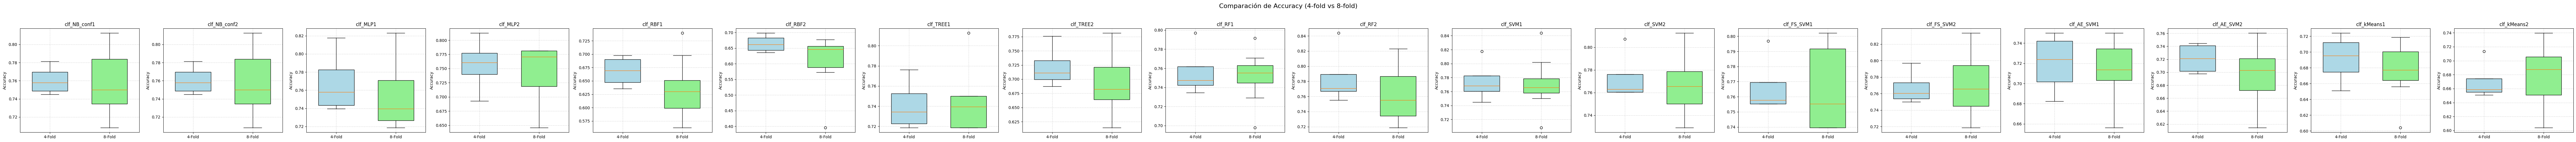

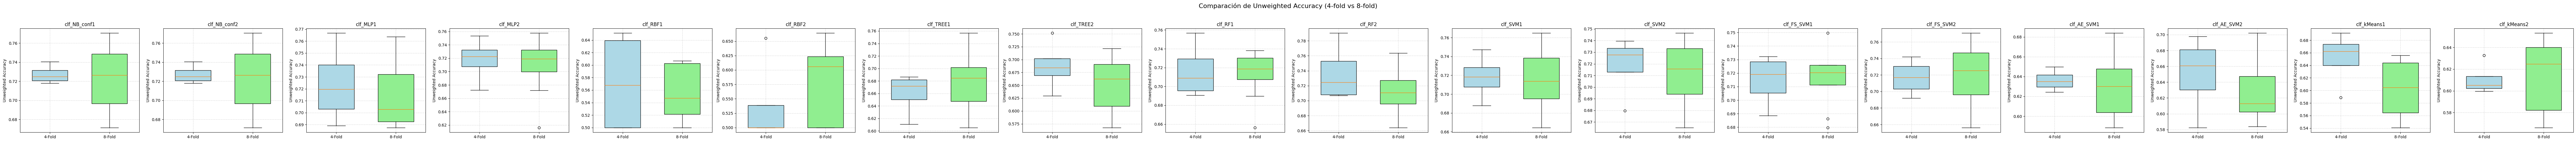

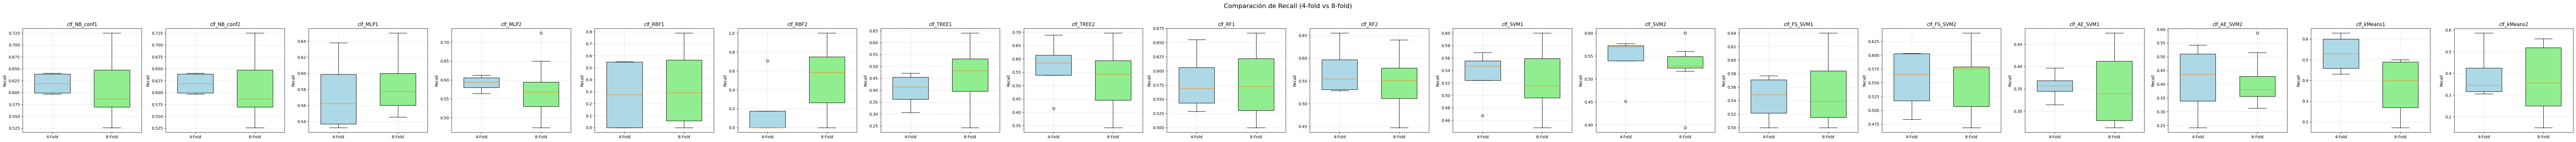

In [53]:
import numpy as np
from sklearn.model_selection import KFold  # o StratifiedKFold si se prefiere
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tabulate import tabulate

# Lista con los números de folds que se desea evaluar
fold_values = [4, 8]

# Diccionario para almacenar los resultados para cada validación (kfold)
results = {}

# Itero sobre cada número de folds (4 y 8)
for NFfolds in fold_values:
    # Inicializo estructuras para cada métrica y para cada clasificador
    Macc = [[] for _ in range(len(classifiers))]
    Muar = [[] for _ in range(len(classifiers))]
    Mrec = [[] for _ in range(len(classifiers))]
    Mnf  = [[] for _ in range(len(classifiers))]

    # Creo el objeto KFold (puede añadirse shuffle si se desea)
    kf = KFold(n_splits=NFfolds, shuffle=True, random_state=42)
    # Si se desea utilizar KFold estratificado, descomente la siguiente línea:
    # kf = StratifiedKFold(n_splits=NFfolds, shuffle=True, random_state=42)

    # Realizo la validación cruzada
    for train_index, test_index in kf.split(X):
        # Asigno datos y etiquetas según los índices del fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        # Estandarización de los datos (sobre cada fold)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test  = scaler.transform(X_test)

        # Llamada a cada clasificador con el fold actual
        for i, clf_name in enumerate(classifiers):
            # Se asume que cada función clasificador está definida en el ámbito local
            acc, uar, rec, nf = locals()[clf_name](X_train, X_test, y_train, y_test)
            Macc[i].append(acc)
            Muar[i].append(uar)
            Mrec[i].append(rec)
            Mnf[i].append(nf)

    # Convierto las listas a arrays para facilitar el cálculo de estadísticas
    Macc = np.array(Macc)
    Muar = np.array(Muar)
    Mrec = np.array(Mrec)
    Mnf  = np.array(Mnf)

    # Calculo las estadísticas: media y desviación estándar
    stats = {
        'acc_mean': np.mean(Macc, axis=1),
        'uar_mean': np.mean(Muar, axis=1),
        'rec_mean': np.mean(Mrec, axis=1),
        'nf_mean':  np.mean(Mnf, axis=1),
        'acc_std':  np.std(Macc, axis=1),
        'uar_std':  np.std(Muar, axis=1),
        'rec_std':  np.std(Mrec, axis=1)
    }

    # Guardo los resultados para el número de folds actual
    results[NFfolds] = {
        'Macc': Macc,
        'Muar': Muar,
        'Mrec': Mrec,
        'Mnf':  Mnf,
        'stats': stats
    }

    # Imprimo una tabla con los resultados para la validación con NFfolds
    print(f"\n::: Resultados de k-Fold CV con n_splits = {NFfolds} :::")
    table = [["Clasificador", "ACC Mean", "ACC STD", "UAR Mean", "UAR STD", "Recall Mean", "Recall STD", "# Features"]]
    for i, clf_name in enumerate(classifiers):
        table.append([
            clf_name[4:],  # Se asume que se quitan los 4 primeros caracteres (por ejemplo, 'clf')
            f"{stats['acc_mean'][i]:.4f}",
            f"{stats['acc_std'][i]:.4f}",
            f"{stats['uar_mean'][i]:.4f}",
            f"{stats['uar_std'][i]:.4f}",
            f"{stats['rec_mean'][i]:.4f}",
            f"{stats['rec_std'][i]:.4f}",
            f"{stats['nf_mean'][i]:.1f}"
        ])
    print(tabulate(table, tablefmt="fancy_grid", showindex="always", stralign="center"))

# ---------------------------------------------------------------------
# Generación de BoxPlots para cada métrica (accuracy, unweighted accuracy y recall)
# Cada figura tendrá un subplot por clasificador, comparando 4-fold vs 8-fold.
# ---------------------------------------------------------------------

# Lista de métricas a graficar: cada entrada es (nombre, etiqueta eje y)
metric_list = [
    ('Macc', 'Accuracy'),
    ('Muar', 'Unweighted Accuracy'),
    ('Mrec', 'Recall')
]

for metric_key, metric_label in metric_list:
    num_classifiers = len(classifiers)
    # Crear figura y ejes (una fila con un subplot por clasificador)
    fig, axes = plt.subplots(1, num_classifiers, figsize=(5*num_classifiers, 5), squeeze=False)
    fig.suptitle(f'Comparación de {metric_label} (4-fold vs 8-fold)', fontsize=16)

    for i, clf_name in enumerate(classifiers):
        # Extraigo los valores de la métrica para el clasificador i para ambos métodos de validación
        values_4fold = results[4][metric_key][i]  # Array con NFfolds=4
        values_8fold = results[8][metric_key][i]  # Array con NFfolds=8

        # Preparar los datos para boxplot: una lista con dos elementos
        data_to_plot = [values_4fold, values_8fold]

        # Boxplot en el subplot correspondiente
        ax = axes[0, i]
        bp = ax.boxplot(data_to_plot, patch_artist=True, widths=0.6)

        # Personalización de colores
        colors = ['lightblue', 'lightgreen']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        ax.set_title(clf_name)
        ax.set_xticks([1, 2])
        ax.set_xticklabels(['4-Fold', '8-Fold'])
        ax.set_ylabel(metric_label)
        ax.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ---------------------------------------------------------------------
# Análisis (comentario):
#
# - Al comparar los BoxPlots para cada métrica se puede observar si existe
#   alguna diferencia en la distribución de los valores obtenidos al utilizar 4 o 8 folds.
# - Una mayor cantidad de folds (8-fold) implica que cada fold es más pequeño, lo que
#   puede derivar en una mayor variabilidad de las métricas; sin embargo, también puede
#   proporcionar una estimación más robusta al aprovechar más particiones.
# - Se recomienda analizar, para cada clasificador, si las medias y las dispersión (medida
#   por la desviación estándar) son consistentes entre ambos métodos de validación.
#
# Con base en el análisis gráfico y en los valores tabulados se podrá concluir cuál método
# resulta más adecuado para el conjunto de datos y los clasificadores considerados.
# ---------------------------------------------------------------------


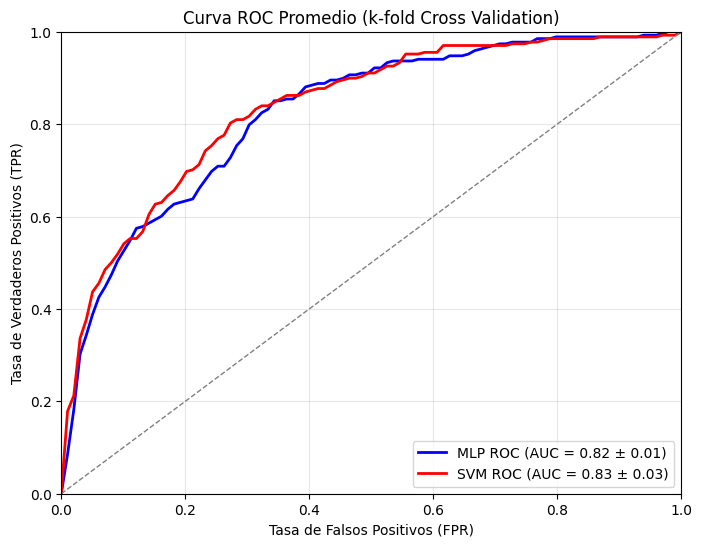

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Asumimos que ya se tienen definidos X (datos) e y (etiquetas binaras, 0 y 1)
# X, y = ... (ejemplo: X = np.array(...), y = np.array(...))

# Parámetros para la validación cruzada
n_splits = 5  # Número de folds para k-fold
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Arrays para almacenar las curvas ROC y AUC de cada fold para cada clasificador
tprs_mlp = []
aucs_mlp = []
tprs_svm = []
aucs_svm = []
# Definimos un eje de FPR fijo para interpolar (por ejemplo, 100 puntos entre 0 y 1)
mean_fpr = np.linspace(0, 1, 100)

# Bucle sobre cada fold
for train_idx, test_idx in cv.split(X, Y):
    # División de datos en entrenamiento y test
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    # Estandarización (importante para ambos clasificadores)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # -----------------------
    # Entrenamiento y evaluación del MLP
    # -----------------------
    mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                        max_iter=300, random_state=42)
    mlp.fit(X_train, y_train)

    # Obtención de las probabilidades para la clase positiva (índice 1)
    y_score_mlp = mlp.predict_proba(X_test)[:, 1]

    # Cálculo de la curva ROC para el MLP
    fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_score_mlp)
    roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
    aucs_mlp.append(roc_auc_mlp)

    # Interpolación del TPR a los puntos definidos en mean_fpr
    tpr_interp_mlp = np.interp(mean_fpr, fpr_mlp, tpr_mlp)
    tpr_interp_mlp[0] = 0.0  # Aseguramos que comience en 0
    tprs_mlp.append(tpr_interp_mlp)

    # -----------------------
    # Entrenamiento y evaluación del SVM
    # -----------------------
    # Usamos SVM lineal para obtener la función de decisión
    svm = SVC(kernel='linear', probability=False, random_state=42)
    svm.fit(X_train, y_train)

    # Obtenemos los scores de la función de decisión
    y_score_svm = svm.decision_function(X_test)

    # Cálculo de la curva ROC para el SVM
    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    aucs_svm.append(roc_auc_svm)

    # Interpolación del TPR para el SVM
    tpr_interp_svm = np.interp(mean_fpr, fpr_svm, tpr_svm)
    tpr_interp_svm[0] = 0.0
    tprs_svm.append(tpr_interp_svm)

# Promedio de las curvas ROC y AUC para el MLP
mean_tpr_mlp = np.mean(tprs_mlp, axis=0)
mean_tpr_mlp[-1] = 1.0
mean_auc_mlp = auc(mean_fpr, mean_tpr_mlp)
std_auc_mlp = np.std(aucs_mlp)

# Promedio de las curvas ROC y AUC para el SVM
mean_tpr_svm = np.mean(tprs_svm, axis=0)
mean_tpr_svm[-1] = 1.0
mean_auc_svm = auc(mean_fpr, mean_tpr_svm)
std_auc_svm = np.std(aucs_svm)

# Graficamos la curva ROC promedio para ambos clasificadores
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr_mlp, color='blue', lw=2,
         label=f'MLP ROC (AUC = {mean_auc_mlp:.2f} ± {std_auc_mlp:.2f})')
plt.plot(mean_fpr, mean_tpr_svm, color='red', lw=2,
         label=f'SVM ROC (AUC = {mean_auc_svm:.2f} ± {std_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Promedio (k-fold Cross Validation)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# ---------------------------------------------------------------------
# Interpretación:
# - Se observa la comparación de las curvas ROC promedio de MLP y SVM.
# - El AUC (area bajo la curva) junto con su desviación estándar se muestran en la leyenda.
# - Un AUC mayor indica mejor desempeño en la discriminación de clases.
# - Se puede analizar cuál de los dos clasificadores presenta un desempeño más robusto
#   según estas métricas.
# ---------------------------------------------------------------------


### **Ejercicio 2: dataset "Iris"**

In [68]:
# carga de datos
iris = load_iris()
# aleatorización
X, Y = shuffle(iris.data, iris.target, random_state=0)
# defino lista de clasificadores
classifiers = ["clf_NB","clf_MLP","clf_RBF","clf_TREE","clf_RF","clf_SVM","clf_FS_SVM","clf_AE_SVM","clf_kMeans"]

**Validación cruzada: particionado simple train/test**

In [69]:
# validación cruzada: partición train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0, shuffle=True, stratify=Y)

# Estandarización de los datos
scaler = StandardScaler()
# Ajuste sobre de train
scaler.fit(X_train)
# transformación de datos train y test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
vacc = []
vuar = []
vnf  = []
# llamada a cada clasificador con el fold actual
for clf in range(0,len(classifiers)):
    acc, uar, _, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
    # guardo las medidas de desempeño en un vector
    vacc.append(acc)
    vuar.append(uar)
    vnf.append(nf)

# imprimo una tabla con los resultados
print(':::                  Simple CV                  :::')
table = [["Clasificador","ACC", "UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([ classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], '%1.1f' % vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

AttributeError: 'SVC' object has no attribute 'SVC'

**K-Fold Cross Validation**

In [ ]:
NFfolds = 4   # >=2

# inicializo estructuras para guardar resultados
Macc = [[] for i in range(len(classifiers))]
Muar = [[] for i in range(len(classifiers))]
Mnf  = [[] for i in range(len(classifiers))]

# Validación cruzada K-Fold (estratificada / no estratificada)

kf = KFold(n_splits=NFfolds)                            # non Stratified KFold
# kf = StratifiedKFold(n_splits=NFfolds)                # Stratified KFold

for train_index, test_index in kf.split(X):

    # asigno datos y etiquetas segun los índices del fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Estandarización de los datos (sobre cada fold)
    scaler = StandardScaler()
    # Ajuste sobre de train
    scaler.fit(X_train)
    # transformación de datos train y test
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # llamada a cada clasificador con el fold actual
    for clf in range(0,len(classifiers)):
        acc, uar, _, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
        # guardo las medidas de desempeño en un vector
        Macc[clf].append(acc)
        Muar[clf].append(uar)
        Mnf[clf].append(nf)

# conversión a array
Macc = np.array(Macc)
Muar = np.array(Muar)
Mnf  = np.array(Mnf)
# estadísticas de desempeño
acc_mean = np.mean(Macc,axis=1)
uar_mean = np.mean(Muar,axis=1)
nf_mean  = np.mean(Mnf,axis=1)
acc_std = np.std(Macc,axis=1)
uar_std = np.std(Muar,axis=1)

# imprimo una tabla con los resultados
print(':::                            k-Ffold CV                               :::')
table = [["Clasificador","ACC Mean","ACC STD","UAR Mean","UAR STD", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % acc_mean[clf], '%.4f' % acc_std[clf], '%.4f' % uar_mean[clf], '%.4f' % uar_std[clf], '%1.1f' % nf_mean[clf]])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

***Repetimos empleando las dos primeras componentes principales***

**Validación cruzada: particionado simple train/test**

In [ ]:
# validación cruzada: partición train/test #

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0, shuffle=True, stratify=Y)

# Estandarización de los datos
scaler = StandardScaler()
# Ajuste sobre de train
scaler.fit(X_train)
# transformación de datos train y test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# PCA: reducción dimensional
pca = PCA(n_components=2)
# Ajuste sobre de train
pca.fit(X_train)
# transformación de datos train y test
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

vacc = []
vuar = []
vnf  = []

# llamada a cada clasificador con el fold actual
for clf in range(0,len(classifiers)):
    acc, uar, _, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
    # guardo las medidas de desempeño en un vector
    vacc.append(acc)
    vuar.append(uar)
    vnf.append(nf)

# imprimo una tabla con los resultados
print(':::                  Simple CV                  :::')
table = [["Clasificador","ACC", "UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([ classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], '%1.1f' % vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

**K-Fold Cross Validation**

In [ ]:
## K-Folds Cross Validation ##

NFfolds = 5   # >=2
Macc = [[] for i in range(len(classifiers))]
Muar = [[] for i in range(len(classifiers))]
Mnf  = [[] for i in range(len(classifiers))]

kf = KFold(n_splits=NFfolds)                            # non Stratified KFold
# kf = StratifiedKFold(n_splits=NFfolds)                # Stratified KFold

for train_index, test_index in kf.split(X):

    # asigno datos y etiquetas segun los índices del fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Estandarización de los datos (sobre cada fold)
    scaler = StandardScaler()
    # Ajuste sobre de train
    scaler.fit(X_train)
    # transformación de datos train y test
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # PCA: reducción dimensional
    pca = PCA(n_components=2)
    # Ajuste sobre de train
    pca.fit(X_train)
    # transformación de datos train y test
    X_PC_train = pca.transform(X_train)
    X_PC_test = pca.transform(X_test)

    # llamada a cada clasificador con el fold actual
    for clf in range(0,len(classifiers)):
        acc, uar, _, nf = locals()[classifiers[clf]](X_PC_train, X_PC_test, y_train, y_test)
        # guardo las medidas de desempeño en un vector
        Macc[clf].append(acc)
        Muar[clf].append(uar)
        Mnf[clf].append(nf)

# convierto a array
Macc = np.array(Macc)
Muar = np.array(Muar)
Mnf  = np.array(Mnf)
# calculo estadísticas
acc_mean = np.mean(Macc,axis=1)
uar_mean = np.mean(Muar,axis=1)
nf_mean  = np.mean(Mnf,axis=1)
acc_std = np.std(Macc,axis=1)
uar_std = np.std(Muar,axis=1)

print(':::                            k-Ffold CV                               :::')
# imprimo una tabla con los resultados
table = [["Clasificador","ACC Mean","ACC STD","UAR Mean","UAR STD", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % acc_mean[clf], '%.4f' % acc_std[clf], '%.4f' % uar_mean[clf], '%.4f' % uar_std[clf], '%1.1f' % nf_mean[clf] ])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

**Graficación de los datos proyectados**

In [ ]:
# Scatter plots empleando el último fold

# PCA: PC1 y PC2
fig, ([fig1, fig2], [fig3, fig4]) = plt.subplots(nrows=2,ncols=2)

fig1.scatter(X_PC_train[:,0], X_PC_train[:,1], s=50, c=y_train, marker="o")
fig1.set_xlabel("PC1")
fig1.set_ylabel("PC2")
fig1.set_title("Train Data")
fig2.scatter(X_PC_test[:,0],  X_PC_test[:,1],  s=50, c=y_test, marker="o")
fig2.set_xlabel("PC1")
fig2.set_ylabel("PC2")
fig2.set_title("Test Data")

# Representaciones latentes Auto-Enconder
_, _, _, _ = clf_AE_SVM(X_train, X_test, y_train, y_test, plot=True, ax1=fig3, ax2=fig4)

plt.draw()
plt.tight_layout(pad=1.08)
plt.show()

### **Ejercicio 3: dataset "Leukemia"**

In [ ]:
# Carga de datos y preprocesamiento
# Leukemia

data_train = pd.read_csv('http://tsam-fich.wikidot.com/local--files/apuntes/leukemia_train.csv', header=None)
data_test  = pd.read_csv('http://tsam-fich.wikidot.com/local--files/apuntes/leukemia_test.csv', header=None)

# separo patrones en X y etiquetas en Y para train y test
X_train = np.array(data_train)[:,:-1]           # patrones train
y_train = np.ravel(np.array(data_train)[:,-1:]) # etiquetas train
X_test = np.array(data_test)[:,:-1]             # patrones test
y_test = np.ravel(np.array(data_test)[:,-1:])   # etiquetas test

# Estandarización
scaler = StandardScaler()
# Ajuste sobre de train
scaler.fit(X_train)
# transformación de datos train y test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# defino lista de clasificadores
classifiers = ["clf_NB","clf_MLP","clf_RBF","clf_TREE","clf_RF","clf_SVM","clf_kMeans"]

**Evaluación de desempeño de los clasificadores empleando las 7129 características**

In [ ]:
vacc = []
vuar = []
vrec = []
vnf  = []

start_time = time.time()
for clf in range(0,len(classifiers)):
    acc, uar, rec, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
    vacc.append(acc)
    vuar.append(uar)
    vrec.append(rec)
    vnf.append(nf)

elapsed_time = time.time() - start_time

print(':::          Complete Feature Set             :::')
table = [["Clasificador","Accuracy","UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", stralign="center"))
print("Tiempo Total Clasificadores: ", '%.4f' % elapsed_time)

**Selección de características mediante método de ranking basado en ANOVA F-value**


In [ ]:
# defino el método de ranking con criterio de ANOVA F (f_classif)
FS = SelectKBest(f_classif, k=20)    # definir cuántas características se desean seleccionar

start_time = time.time()
# realizo la selección en base a datos de train
FS = FS.fit(X_train, y_train)
elapsed_time = time.time() - start_time
# aplico la selección en train y test
X_train_new = FS.transform(X_train)
X_test_new  = FS.transform(X_test)

vacc = []
vuar = []
vnf  = []

start_time = time.time()
# Evaluación de clasificadores con las características seleccionadas
for clf in range(0,len(classifiers)):
    acc, uar, _, nf = locals()[classifiers[clf]](X_train_new, X_test_new, y_train, y_test)
    vacc.append(acc)
    vuar.append(uar)
    vnf.append(nf)

elapsed_time_2 = time.time() - start_time

print(':::   K-Best Ranking based on ANOVA F-value   :::')
table = [["Clasificador","Accuracy","UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf],  vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", stralign="center"))
print("Tiempo Selección de Características: ", '%.4f' % elapsed_time)
print("Tiempo Total Clasificadores: ", '%.4f' % elapsed_time_2)

**Selección de características mediante el método Eliminación Recursiva (RFE) empleando SVM lineal**


In [ ]:
# Defino método de evaluación
estimator = LinearSVC(random_state=0, tol=1e-5)
# Defino método de búsqueda
FS = RFE(estimator, n_features_to_select=20,       # definir cuántas características se desean seleccionar
         step=1)                                   # definir cuántas características se eliminan en cada iteración

start_time = time.time()
# Selección de características sobre datos de train
FS = FS.fit(X_train, y_train)
elapsed_time = time.time() - start_time
# Aplico selección en train y test
X_train_new = FS.transform(X_train)
X_test_new  = FS.transform(X_test)

vacc = []
vuar = []
vnf  = []

start_time = time.time()
# Evaluación de clasificadores con las características seleccionadas
for clf in range(0,len(classifiers)):
    acc, uar, _, nf = locals()[classifiers[clf]](X_train_new, X_test_new, y_train, y_test)
    vacc.append(acc)
    vuar.append(uar)
    vnf.append(nf)
elapsed_time_2 = time.time() - start_time

print(':::             RFE - linear SVM              :::')
table = [["Clasificador","Accuracy","UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", stralign="center"))
print("Tiempo Selección de Características: ", '%.4f' % elapsed_time)
print("Tiempo Total Clasificadores: ", '%.4f' % elapsed_time_2)

**Selección de características mediante el método Relief**


In [ ]:
# Selección de características mediante Relief

FS = relief.Relief(n_features=20) # definir cuántas características se desean seleccionar

start_time = time.time()
# Selección de características sobre datos de train
FS = FS.fit(X_train, y_train)
elapsed_time = time.time() - start_time
# Aplico selección en train y test
X_train_new = FS.transform(X_train)
X_test_new  = FS.transform(X_test)

vacc = []
vuar = []
vnf  = []

start_time = time.time()
# Evaluación de clasificadores con las características seleccionadas
for clf in range(0,len(classifiers)):
    acc, uar, _, nf = locals()[classifiers[clf]](X_train_new, X_test_new, y_train, y_test)
    vacc.append(acc)
    vuar.append(uar)
    vnf.append(nf)
elapsed_time_2 = time.time() - start_time

print(':::                  Relief                   :::')
table = [["Clasificador","Accuracy","UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", stralign="center"))
print("Tiempo Selección de Características: ", '%.4f' % elapsed_time)
print("Tiempo Total Clasificadores: ", '%.4f' % elapsed_time_2)